In [195]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats
from collections import namedtuple
import json
import importlib
import scipy.stats as stats

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/FamilySeqError/parameter_estimation/compare_rates.py'>

In [196]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# Set up plotting. 

In [286]:
def plot_precision_recall(filename, datasets, ylim=[0, 5], 
                          dotted=False, rotate_xlabels=False, legend_labels=None, legend_colors=None, xlabel=None, 
                          figsize=(10, 6), log=True):
    fig, subs = plt.subplots(2, 2, sharey=True, figsize=figsize)    
    
    for k, gen in enumerate(['1', '2']):
        for l, attr in enumerate(['precision', 'recall']):
            error_estimates = [d[attr + gen + '_estimates'] for d in datasets]
            upper_bounds = [d[attr + gen + '_upper_bounds'] for d in datasets]
            
            upper_bound = [np.median(ub) for ub in upper_bounds]
            lower_bound = [0]*len(datasets)
            for j in range(len(datasets)):
                if log:
                    subs[l, k].fill([j+0.7, j+0.7, j+1.3, j+1.3], [-np.log10(1-lower_bound[j]), -np.log10(1-upper_bound[j]), -np.log10(1-upper_bound[j]), -np.log10(1-lower_bound[j])],
                                lw=0, c='lightgray', zorder=-10)
                else:
                    subs[l, k].fill([j+0.7, j+0.7, j+1.3, j+1.3], [lower_bound[j], upper_bound[j], upper_bound[j], lower_bound[j]],
                                lw=0, c='lightgray', zorder=-10)

            if log:
                data = [-np.log10(1-np.clip(ee, None, ub)) for ee, ub in zip(error_estimates, upper_bounds)]
            else:
                data = [np.clip(ee, None, ub) for ee, ub in zip(error_estimates, upper_bounds)]
            print('n=', [d.shape[0] for d in data])
            print(attr+gen, [1-np.median(x) for x in error_estimates])
            parts = subs[l, k].violinplot(data, showmedians=True, showextrema=False, widths=0.8)


            if dotted:
                if log:
                    subs[l, k].plot(np.arange(1, 1+len(datasets)), 
                                [np.median(-np.log10(1-datasets[0][attr + gen + '_estimates']))]*len(datasets), 
                                color='black', linestyle='--')
                else:
                    subs[l, k].plot(np.arange(1, 1+len(datasets)), 
                                [np.median(datasets[0][attr + gen + '_estimates'])]*len(datasets), 
                                color='black', linestyle='--')


            for pc, d in zip(parts['bodies'], datasets):
                pc.set_facecolor(d['color'])
                pc.set_edgecolor('black')
                pc.set_alpha(1)
            parts['cmedians'].set_edgecolor('black')
            parts['cmedians'].set_linewidth(2)
                
            subs[l, k].grid(True, axis='y', color='darkgray')
            subs[l, k].set_axisbelow(True)
            subs[l, k].set_ylim(ylim)

    # yticks only on leftmost panels
    if log:
        yticks = np.arange(1, ylim[1])
        ytick_labels = ['0.' + '9'*int(f) % f for f in yticks]
    else:
        yticks = np.arange(0.9, 1.02, 0.2)
        ytick_labels = [str(x) for x in yticks]
    subs[0, 0].set_yticks(yticks)
    subs[0, 0].set_yticklabels(ytick_labels, {'fontsize': 15})
    subs[0, 1].tick_params('y', length=0)
    subs[1, 0].set_yticks(yticks)
    subs[1, 0].set_yticklabels(ytick_labels, {'fontsize': 15})
    subs[1, 1].tick_params('y', length=0)
    subs[0, 0].set_ylabel('Precision', {'fontsize':18})
    subs[1, 0].set_ylabel('Recall', {'fontsize':18})
    
    # xticks only on bottom panels
    subs[0, 0].set_xticks([])
    subs[0, 1].set_xticks([])
    subs[1, 0].set_xticks(np.arange(1, 1+len(datasets)))
    subs[1, 0].set_xticklabels([d['name'] for d in datasets], {'fontsize': 15})
    subs[1, 1].set_xticks(np.arange(1, 1+len(datasets)))
    subs[1, 1].set_xticklabels([d['name'] for d in datasets], {'fontsize': 15})
    if rotate_xlabels:
        for tick in subs[1, 0].get_xticklabels():
            tick.set_rotation(90)
        for tick in subs[1, 1].get_xticklabels():
            tick.set_rotation(90)
    if xlabel is not None:
        fig.text(0.5, 0.1, xlabel, ha='center', va='center', fontsize=15)
    
    # titles only on topmost panels
    subs[0, 0].set_title('Heterozygous Sites', {'fontsize': 18}, loc='left')
    subs[0, 1].set_title('Homozygous Alt. Sites', {'fontsize': 18}, loc='left')
    subs[1, 0].set_title(None)
    subs[1, 1].set_title(None)
    
    # legend
    if legend_labels is not None:
        entries = []
        for label, color in zip(legend_labels, legend_colors):
            entries.append(patches.Patch(color=color, label=label))
        subs[1, 1].legend(handles=entries, loc='lower center', ncol=3,
                                    bbox_to_anchor=(0, -0.5), borderaxespad=0., fontsize=15, frameon=False)
    
    
    fig.subplots_adjust(wspace=0.0, hspace=0.0, top=0.9, bottom=0.3 if rotate_xlabels else 0.2)
    #plt.show()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

# Compare platforms

In [248]:
ihart_is_ok_sample = set()
with open('../../PhasingFamilies/data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] == 'Passed_QC_analysis_ready':
            ihart_is_ok_sample.add(pieces[2])


In [260]:
ihart_wgs_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts', chroms)
ihart_chip_samples = compare_rates.pull_samples('../../DATA/ihart.chip/family_genotype_counts', chroms)
ihart_chip_num_sites = compare_rates.pull_num_sites(ihart_chip_samples, '../../FamilySeqError/params/ihart.chip_params.json')

datasets_of_interest = [
    {'name': 'iHART\nWGS',
     'color': '#4db6ac',
     'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.ms2_params.json',
     'sample_filter': lambda x: x.is_child & np.array([x in ihart_is_ok_sample for x in ihart_wgs_samples.sample_ids])
    },
    {'name': 'SSC\nWGS',
     'color': '#4db6ac',
     'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-3',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-4',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-5',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-7',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase4',
                             '../../DATA/ssc.hg38/family_genotype_counts/pilot'
                            ],
     'param_file': ['../../FamilySeqError/params/ssc.hg38_phase1-1_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-3_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-4_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-5_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-7_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_B01_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_Replacements_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_B02_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase4_params.json',
                   '../../FamilySeqError/params/ssc.hg38_pilot_params.json'
                   ],
     'sample_filter': lambda x: x.is_child
    },
    {'name': 'SPARK\nWES',
     'color': '#ef6c00',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX',
     'param_file': '../../FamilySeqError/params/spark.exome_EX_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': 'IHART\nArray',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/ihart.chip/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.chip_params.json',
     'sample_filter': lambda x: x.is_child & (np.array(ihart_chip_num_sites) > 300000)
    },
    {'name': 'SPARK\nArray',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/spark/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/spark_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
{'name': 'iHART\nWGS', 'color': '#4db6ac', 'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts', 'param_file': '../../FamilySeqError/params/ihart.ms2_params.json', 'sample_filter': <function <lambda> at 0x1a1ed0d8c8>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 1781
num removed due to missing 215
num removed due to too many non-Mendelian sites 14
(2009,)
(2009,) (2009,)
(2009,) (2009,)
(2009,) (2009,)
(2009,) (2009,)
{'name': 'SSC\nWGS', 'color': '#4db6ac', 'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1', '../../DATA/ssc.hg38/family_genotype_counts/phase1-2', '../../DATA/ssc.hg38/family_genotype_counts/phase1-3', '../../DA

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater


num removed due to missing 2
num removed due to too many non-Mendelian sites 76
(695,)
(695,) (695,)
(695,) (695,)
(695,) (695,)
(695,) (695,)
{'name': 'SPARK\nArray', 'color': '#ce93d8', 'family_genotype_dir': '../../DATA/spark/family_genotype_counts', 'param_file': '../../FamilySeqError/params/spark_params.json', 'sample_filter': <function <lambda> at 0x1a1ed0de18>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 6478
num removed due to missing 19
num removed due to too many non-Mendelian sites 44
(6683,)
(6683,) (6683,)
(6683,) (6683,)
(6683,) (6683,)
(6683,) (6683,)


n= [2009, 3941, 9571, 695, 6683]
precision1 [0.0010564347281890596, 0.003930715257292494, 0.002644072954079202, 4.100719985800083e-09, 0.0002160711144849614]
n= [2009, 3941, 9571, 695, 6683]
recall1 [0.0017887018462632298, 0.002009767843195953, 0.00797701998678868, 0.001362801953252335, 0.005270802005821529]
n= [2009, 3941, 9571, 695, 6683]
precision2 [0.0014671805146689865, 0.0005876230658244941, 0.0025541795816055313, 0.0004818029273517821, 0.00072339902690155]
n= [2009, 3941, 9571, 695, 6683]
recall2 [0.000577596940429137, 0.0006894660615742731, 0.0009964741120290777, 0.0006862456003082773, 0.00480896763840144]


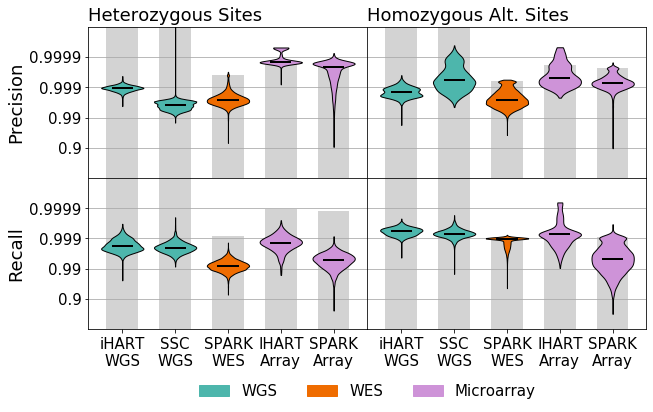

In [271]:
plot_precision_recall('../plots/sequencing_method.eps',
                      datasets_of_interest,
                      legend_labels=['WGS', 'WES', 'Microarray'], 
                      legend_colors=['#4db6ac', '#ef6c00', '#ce93d8'],
                      #figsize=(11, 6)
                     )

# GATK v3.2 vs v3.4

In [209]:

datasets_of_interest = [
    {'name': 'ihart v3.2',
     'color': '#009668',
     'family_genotype_dir': '../../DATA/ihart.v32/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.v32_params.json',
     'sample_filter': lambda x: x.is_child
    },
    
    {'name': 'ihart v3.4',
     'color': '#cedd38',
     'family_genotype_dir': '../../DATA/ihart.v34/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.v34_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

{'name': 'ihart v3.2', 'color': '#009668', 'family_genotype_dir': '../../DATA/ihart.v32/family_genotype_counts', 'param_file': '../../FamilySeqError/params/ihart.v32_params.json', 'sample_filter': <function <lambda> at 0x1a1d8c3048>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 866
num removed due to missing 0
num removed due to too many non-Mendelian sites 24
(1165,)
(1165,) (1165,)
(1165,) (1165,)
(1165,) (1165,)
(1165,) (1165,)
{'name': 'ihart v3.4', 'color': '#cedd38', 'family_genotype_dir': '../../DATA/ihart.v34/family_genotype_counts', 'param_file': '../../FamilySeqError/params/ihart.v34_params.json', 'sample_filter': <function <lambda> at 0x1a1d8c3ea0>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 1763
num removed due to missing 202
num removed due to too many non-Mendelian sites 18
(2034,)
(

965
Precision Het 0.0010459698467695 -0.1352288017235323
Precision Hom Alt 4.118920376274113e-05 -0.08096484586173237
Recall Het 0.0003416473427211311 -0.15202278526697732
Recall Hom Alt 0.00012871417814918322 -0.1369366108009418


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


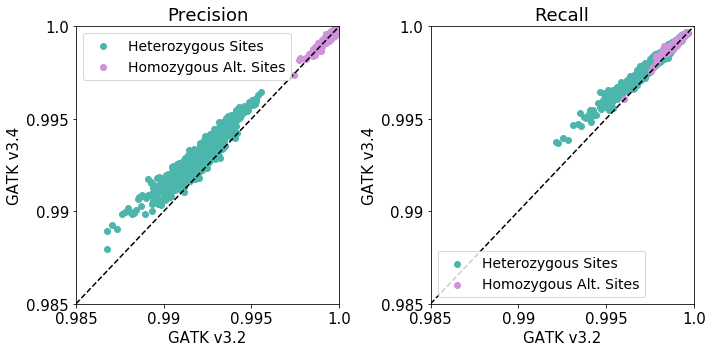

In [210]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

shared_samples = sorted(set(datasets_of_interest[0]['precision1_samples']) & set(datasets_of_interest[1]['precision1_samples']))
print(len(shared_samples))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision1_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Precision Het', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['precision2_samples']) & set(datasets_of_interest[1]['precision2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision2_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Precision Hom Alt', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

plt.xlabel('GATK v3.2', fontsize=15)
plt.ylabel('GATK v3.4', fontsize=15)
ticks = [0.985, 0.990, 0.995, 1.0]
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Precision', fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

shared_samples = sorted(set(datasets_of_interest[0]['recall1_samples']) & set(datasets_of_interest[1]['recall1_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall1_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Recall Het', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['recall2_samples']) & set(datasets_of_interest[1]['recall2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall2_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Recall Hom Alt', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

plt.xlabel('GATK v3.2', fontsize=15)
plt.ylabel('GATK v3.4', fontsize=15)
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Recall', fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/gatk.eps')
plt.show()

# GRCh37 vs GRCh38

In [218]:

datasets_of_interest = [
    {'name': 'GRCh37',
     'color': '#009668',
     'family_genotype_dir': ['../../DATA/ihart.v34/family_genotype_counts',
                             '../../DATA/ssc/family_genotype_counts'],
     'param_file': ['../../FamilySeqError/params/ihart.v34_params.json'],
     'sample_filter': lambda x: x.is_child
    },
    
    {'name': 'GRCh38',
     'color': '#cedd38',
     'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.ms2_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

{'name': 'GRCh37', 'color': '#009668', 'family_genotype_dir': ['../../DATA/ihart.v34/family_genotype_counts', '../../DATA/ssc/family_genotype_counts'], 'param_file': ['../../FamilySeqError/params/ihart.v34_params.json'], 'sample_filter': <function <lambda> at 0x1a18b3cea0>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 1763
num removed due to missing 202
num removed due to too many non-Mendelian sites 18
(2034,)
(2034,) (2034,)
(2034,) (2034,)
(2034,) (2034,)
(2034,) (2034,)
{'name': 'GRCh38', 'color': '#cedd38', 'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts', 'param_file': '../../FamilySeqError/params/ihart.ms2_params.json', 'sample_filter': <function <lambda> at 0x1a18b3c9d8>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 1763
num removed due to missing 199
num removed due to t

1993
Precision Het 0.004798831911468078 -0.813744145596178
Precision Hom Alt -0.0011590641366409445 2.926843901649179
Recall Het -0.00025095561755832726 0.15443509557068633
Recall Hom Alt 0.00010451064753447098 -0.1449722970162884


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


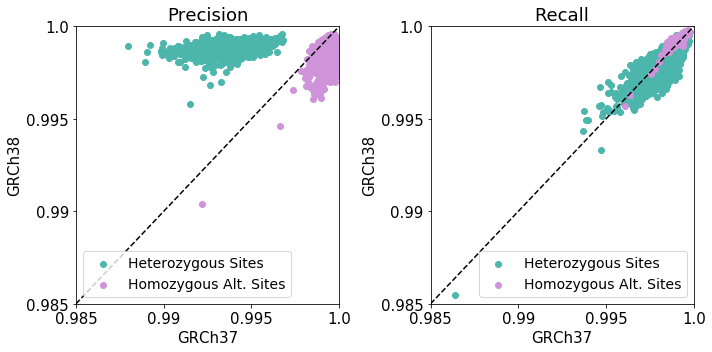

In [219]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

shared_samples = sorted(set(datasets_of_interest[0]['precision1_samples']) & set(datasets_of_interest[1]['precision1_samples']))
print(len(shared_samples))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision1_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Precision Het', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['precision2_samples']) & set(datasets_of_interest[1]['precision2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision2_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Precision Hom Alt', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

plt.xlabel('GRCh37', fontsize=15)
plt.ylabel('GRCh38', fontsize=15)
ticks = [0.985, 0.990, 0.995, 1.0]
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Precision', fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

shared_samples = sorted(set(datasets_of_interest[0]['recall1_samples']) & set(datasets_of_interest[1]['recall1_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall1_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Recall Het', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['recall2_samples']) & set(datasets_of_interest[1]['recall2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall2_estimates'][sample_to_index[s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Recall Hom Alt', np.mean(data[:, 1]-data[:, 0]), np.mean((1-data[:, 1])-(1-data[:, 0]))/(1-np.mean(data[:, 0])))

plt.xlabel('GRCh37', fontsize=15)
plt.ylabel('GRCh38', fontsize=15)
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Recall', fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/reference.eps')
plt.show()

# LCR vs HCR

In [220]:

datasets_of_interest = [
    {'name': 'LCR',
     'color': '#009668',
     'family_genotype_dir': ['../../DATA/ihart.ms2/family_genotype_counts/LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-1_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-2_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-3_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-4_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-5_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-7_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_2_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase4_LCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/pilot_LCR'
                            ],
     'param_file': ['../../FamilySeqError/params/ihart.ms2_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-1_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-2_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-3_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-4_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-5_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-7_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_B01_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_Replacements_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_1_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_1_B02_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_2_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase4_LCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_pilot_LCR_params.json'
                   ],
                   
     'sample_filter': lambda x: x.is_child
    },
    
    {'name': 'HCR',
     'color': '#cedd38',
     'family_genotype_dir': ['../../DATA/ihart.ms2/family_genotype_counts/HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-1_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-2_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-3_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-4_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-5_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-7_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_2_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase4_HCR',
                             '../../DATA/ssc.hg38/family_genotype_counts/pilot_HCR'
                            ],
                            
     'param_file': ['../../FamilySeqError/params/ihart.ms2_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-1_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-2_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-3_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-4_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-5_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase1-7_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_B01_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase2_Replacements_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_1_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_1_B02_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase3_2_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_phase4_HCR_params.json',
                    '../../FamilySeqError/params/ssc.hg38_pilot_HCR_params.json'
                   ],
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

{'name': 'LCR', 'color': '#009668', 'family_genotype_dir': ['../../DATA/ihart.ms2/family_genotype_counts/LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-1_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-2_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-3_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-4_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-5_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase1-7_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase2_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase3_2_LCR', '../../DATA/ssc.hg38/family_genotype_counts/phase4_LCR', '../../DATA/ssc.hg38/family_genotype_counts/pilot_LCR'], 'param_file': ['../../FamilySeqError/params/ihart.ms

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 200
num removed due to missing 0
num removed due to too many non-Mendelian sites 0
(200,)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 200
num removed due to missing 0
num removed due to too many non-Mendelian sites 2
(198,)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 158
num removed due to missing 0
num removed due to too many non-Mendelian sites 0
(158,)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 26
num removed due to missing 0
num removed due to too many non-Mendelian sites 0
(26,)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals i

5645
Precision Het 0.9899661999184602
Precision Homalt 1.1943502750577708
Recall Het 0.8762026782627165
Recall Homalt 1.0394940061260278


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


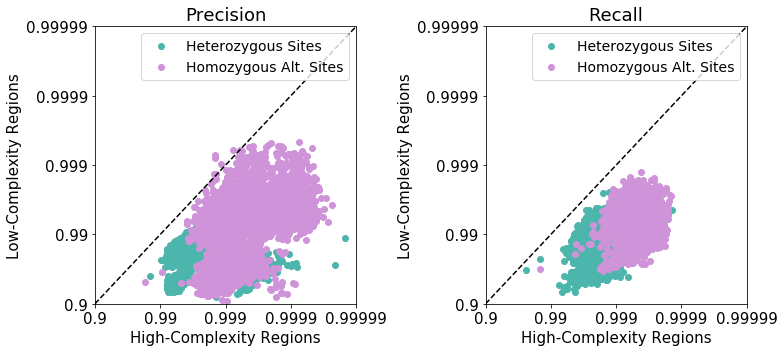

In [221]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)

shared_samples = sorted(set(datasets_of_interest[0]['precision1_samples']) & set(datasets_of_interest[1]['precision1_samples']))
print(len(shared_samples))

data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision1_estimates'][sample_to_index[s]]
plt.scatter(-np.log10(1-data[:, 1]), -np.log10(1-data[:, 0]), color='#4db6ac', label='Heterozygous Sites')
print('Precision Het', np.mean(-np.log10(1-data[:, 1])--np.log10(1-data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['precision2_samples']) & set(datasets_of_interest[1]['precision2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['precision2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['precision2_estimates'][sample_to_index[s]]
plt.scatter(-np.log10(1-data[:, 1]), -np.log10(1-data[:, 0]), color='#ce93d8', label='Homozygous Alt. Sites')
print('Precision Homalt', np.mean(-np.log10(1-data[:, 1])--np.log10(1-data[:, 0])))

plt.ylabel('Low-Complexity Regions', fontsize=15)
plt.xlabel('High-Complexity Regions', fontsize=15)
ticks = [1, 2, 3, 4, 5]
plt.xticks(ticks, [str(1-(10**-x)) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(1-(10**-x)) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Precision', fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

shared_samples = sorted(set(datasets_of_interest[0]['recall1_samples']) & set(datasets_of_interest[1]['recall1_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall1_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall1_estimates'][sample_to_index[s]]
plt.scatter(-np.log10(1-data[:, 1]), -np.log10(1-data[:, 0]), color='#4db6ac', label='Heterozygous Sites')
print('Recall Het', np.mean(-np.log10(1-data[:, 1])--np.log10(1-data[:, 0])))

shared_samples = sorted(set(datasets_of_interest[0]['recall2_samples']) & set(datasets_of_interest[1]['recall2_samples']))
data = np.zeros((len(shared_samples), 2))
for j, d in enumerate(datasets_of_interest):
    sample_to_index = dict([(x, i) for i, x in enumerate(d['recall2_samples'])])
    for k, s in enumerate(shared_samples):
        data[k, j] = d['recall2_estimates'][sample_to_index[s]]
plt.scatter(-np.log10(1-data[:, 1]), -np.log10(1-data[:, 0]), color='#ce93d8', label='Homozygous Alt. Sites')
print('Recall Homalt', np.mean(-np.log10(1-data[:, 1])--np.log10(1-data[:, 0])))

plt.ylabel('Low-Complexity Regions', fontsize=15)
plt.xlabel('High-Complexity Regions', fontsize=15)
plt.xticks(ticks, [str(1-(10**-x)) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(1-(10**-x)) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Recall', fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/lcr.eps')
plt.show()

# WGS at GWAS hits vs microarray.

In [280]:
ihart_wgs_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts', chroms)
ihart_chip_samples = compare_rates.pull_samples('../../DATA/ihart.chip/family_genotype_counts', chroms)
ihart_chip_num_sites = compare_rates.pull_num_sites(ihart_chip_samples, '../../FamilySeqError/params/ihart.chip_params.json')

datasets_of_interest = [
    {'name': 'iHART\nWGS',
     'color': '#4db6ac',
     'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts/GWAS',
     'param_file': '../../FamilySeqError/params/ihart.ms2_GWAS_params.json',
     'sample_filter': lambda x: x.is_child & np.array([x in ihart_is_ok_sample for x in ihart_wgs_samples.sample_ids])
    },
    {'name': 'SSC\nWGS',
     'color': '#4db6ac',
     'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-2_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-3_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-4_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-5_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-7_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_2_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase4_GWAS',
                             '../../DATA/ssc.hg38/family_genotype_counts/pilot_GWAS'
                            ],
     'param_file': ['../../FamilySeqError/params/ssc.hg38_phase1-1_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-2_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-3_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-4_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-5_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-7_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_B01_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_Replacements_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_B02_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_2_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase4_GWAS_params.json',
                   '../../FamilySeqError/params/ssc.hg38_pilot_GWAS_params.json'
                   ],
     'sample_filter': lambda x: x.is_child
    },
    {'name': 'IHART\nArray',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/ihart.chip/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.chip_params.json',
     'sample_filter': lambda x: x.is_child & (np.array(ihart_chip_num_sites) > 300000)
    },
    {'name': 'SPARK\nArray',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/spark/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/spark_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
{'name': 'iHART\nWGS', 'color': '#4db6ac', 'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts/GWAS', 'param_file': '../../FamilySeqError/params/ihart.ms2_GWAS_params.json', 'sample_filter': <function <lambda> at 0x1a1b548ae8>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
num removed due to filter 1781
num removed due to missing 0
num removed due to too many non-Mendelian sites 14
(2224,)
(2224,) (2224,)
(2224,) (2224,)
(2224,) (2224,)
(2224,) (2224,)
{'name': 'SSC\nWGS', 'color': '#4db6ac', 'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1_GWAS', '../../DATA/ssc.hg38/family_genotype_counts/phase1-2_GWAS', '../../DATA/ssc.hg38/family_genotype_counts/ph

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater


num removed due to filter 1462
num removed due to missing 2
num removed due to too many non-Mendelian sites 76
(695,)
(695,) (695,)
(695,) (695,)
(695,) (695,)
(695,) (695,)
{'name': 'SPARK\nArray', 'color': '#ce93d8', 'family_genotype_dir': '../../DATA/spark/family_genotype_counts', 'param_file': '../../FamilySeqError/params/spark_params.json', 'sample_filter': <function <lambda> at 0x1a1b5488c8>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 6478
num removed due to missing 19
num removed due to too many non-Mendelian sites 44
(6683,)
(6683,) (6683,)
(6683,) (6683,)
(6683,) (6683,)
(6683,) (6683,)


n= [2224, 3944, 695, 6683]
precision1 [0.00014275086765735967, 0.00021016726561140509, 4.100719985800083e-09, 0.0002160711144849614]
n= [2224, 3944, 695, 6683]
recall1 [0.0007903891365739213, 0.0008913005506920868, 0.001362801953252335, 0.005270802005821529]
n= [2224, 3944, 695, 6683]
precision2 [0.0004641516445207383, 0.000565810942888989, 0.0004818029273517821, 0.00072339902690155]
n= [2224, 3944, 695, 6683]
recall2 [0.0002398551736195742, 0.0002560079882143462, 0.0006862456003082773, 0.00480896763840144]


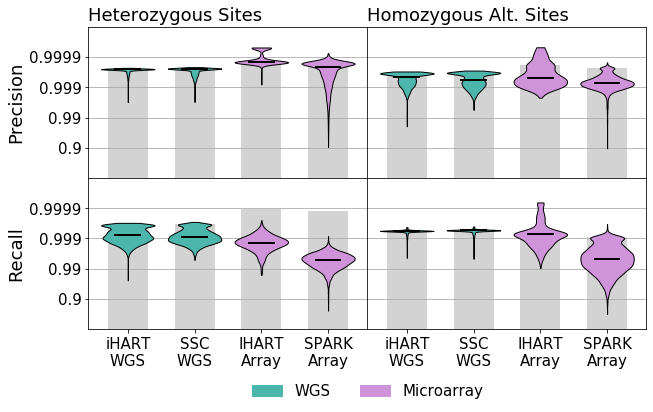

In [291]:
plot_precision_recall('../plots/gwas.eps',
                      datasets_of_interest,
                      legend_labels=['WGS', 'Microarray'], 
                      legend_colors=['#4db6ac', '#ce93d8'],
                      log=True,
                      #figsize=(11, 6)
                     )

# Exome distance from target

In [272]:
datasets_of_interest = [
    {'name': 'In target',
     'color': '#ef6c00',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX',
     'param_file': '../../FamilySeqError/params/spark.exome_EX_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': '0-25bp',
     'color': '#cedd38',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX25',
     'param_file': '../../FamilySeqError/params/spark.exome_EX25_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': '25-50bp',
     'color': '#4db6ac',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX50',
     'param_file': '../../FamilySeqError/params/spark.exome_EX50_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': '50-75bp',
     'color': '#009668',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX75',
     'param_file': '../../FamilySeqError/params/spark.exome_EX75_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': '>75bp',
     'color': '#b3a77d',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX1000',
     'param_file': '../../FamilySeqError/params/spark.exome_EX1000_params.json',
     'sample_filter': lambda x: x.is_child
    },
]


compare_rates.process_datasets(datasets_of_interest, chroms)

{'name': 'In target', 'color': '#ef6c00', 'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX', 'param_file': '../../FamilySeqError/params/spark.exome_EX_params.json', 'sample_filter': <function <lambda> at 0x1a22051e18>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 11806
num removed due to missing 13
num removed due to too many non-Mendelian sites 19
(9571,)
(9571,) (9571,)
(9571,) (9571,)
(9571,) (9571,)
(9571,) (9571,)
{'name': '0-25bp', 'color': '#cedd38', 'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX25', 'param_file': '../../FamilySeqError/params/spark.exome_EX25_params.json', 'sample_filter': <function <lambda> at 0x1a22051730>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 11806
num removed due to missing 2
num removed due to too many non-Mendeli

n= [9571, 9592, 9596, 9591, 9597]
precision1 [0.002644072954079202, 0.0026978235618073665, 0.004257839708162958, 0.008380289171656341, 0.009691649672706415]
n= [9571, 9592, 9596, 9591, 9597]
recall1 [0.00797701998678868, 0.009231757951705832, 0.01857862660020737, 0.039933890506219316, 0.04902227476296195]
n= [9571, 9592, 9596, 9591, 9597]
precision2 [0.0025541795816055313, 0.00215189370070179, 0.004188658081152874, 0.008669796557008724, 0.011422587155373587]
n= [9571, 9592, 9596, 9591, 9597]
recall2 [0.0009964741120290777, 0.0017622205072913566, 0.003958851250198014, 0.010141106235110775, 0.01227067071088872]


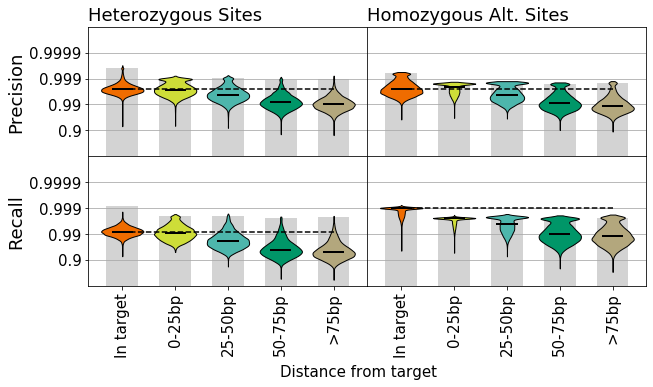

In [273]:
plot_precision_recall('../plots/wes.eps',
                      datasets_of_interest,
                      dotted=True, rotate_xlabels=True, xlabel='Distance from target',
                     )

# LCL vs WB

In [292]:

datasets_of_interest = [
    {'name': 'ihart',
     'color': '#009668',
     'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts/lcls',
     'param_file': '../../FamilySeqError/params/ihart.ms2_lcls_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


compare_rates.process_datasets(datasets_of_interest, chroms)

{'name': 'ihart', 'color': '#009668', 'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts/lcls', 'param_file': '../../FamilySeqError/params/ihart.ms2_lcls_params.json', 'sample_filter': <function <lambda> at 0x1a19309400>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
num removed due to filter 34
num removed due to missing 0
num removed due to too many non-Mendelian sites 0
(67,)
(67,) (67,)
(67,) (67,)
(67,) (67,)
(67,) (67,)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


17
Precision Het -0.0005946676821733763
Ttest_relResult(statistic=15.599288482478553, pvalue=4.240198029869996e-11)
0.9989710179469329 0.9983706029289886
(17, 2) (0.7919057652712095, 0.0001515785985084435)
17
Precision Homalt -0.0005943155716060196
Ttest_relResult(statistic=14.90938656690848, pvalue=8.367314482405457e-11)
0.9989046998364788 0.9982284807906928
(0.9672265744164316, 2.453068776229718e-10)
17
Recall Het 0.0010427257040867392
Ttest_relResult(statistic=-7.117448186881594, pvalue=2.4405838242955338e-06)
0.9978568223859666 0.9988731065265233
(0.8113641625993856, 7.712654962988835e-05)
17
Recall Homalt [ 1.97598254e-04 -2.85572277e-05  3.67783797e-04  6.37734166e-04
  1.99194544e-04  3.77007436e-04  2.82105908e-04  4.85135930e-04
  4.92983200e-04  4.10214496e-04  5.37137062e-04  4.94885932e-04
  2.19562635e-04  3.48916387e-04  2.76501621e-04  3.10796882e-04
  3.75410764e-04]
Ttest_relResult(statistic=-9.172856697017696, pvalue=9.00469713216155e-08)
0.9991730681983771 0.99951703

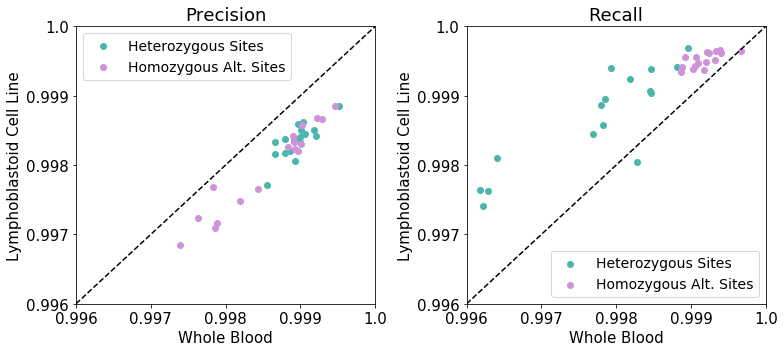

In [298]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)

d = datasets_of_interest[0]

lcl_samples = [x for x in d['precision1_samples'] if x.endswith('_LCL') and x[:-4] in d['precision1_samples']]
wb_samples = [x[:-4] for x in lcl_samples]
print(len(lcl_samples))

data = np.zeros((len(lcl_samples), 2))
sample_to_index = dict([(x, i) for i, x in enumerate(d['precision1_samples'])])
for k, (lcl_s, wb_s) in enumerate(zip(lcl_samples, wb_samples)):
    data[k, 0] = d['precision1_estimates'][sample_to_index[wb_s]]
    data[k, 1] = d['precision1_estimates'][sample_to_index[lcl_s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Precision Het', np.mean(data[:, 1]-data[:, 0]))
print(stats.ttest_rel(data[:, 0], data[:, 1]))
print(np.median(data[:, 0]), np.median(data[:, 1]))
print(data.shape, stats.pearsonr(data[:, 0], data[:, 1]))
lcl_samples = [x for x in d['precision1_samples'] if x.endswith('_LCL') and x[:-4] in d['precision2_samples']]
wb_samples = [x[:-4] for x in lcl_samples]
print(len(lcl_samples))

data = np.zeros((len(lcl_samples), 2))
sample_to_index = dict([(x, i) for i, x in enumerate(d['precision2_samples'])])
for k, (lcl_s, wb_s) in enumerate(zip(lcl_samples, wb_samples)):
    data[k, 0] = d['precision2_estimates'][sample_to_index[wb_s]]
    data[k, 1] = d['precision2_estimates'][sample_to_index[lcl_s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Precision Homalt', np.mean(data[:, 1]-data[:, 0]))
print(stats.ttest_rel(data[:, 0], data[:, 1]))
print(np.median(data[:, 0]), np.median(data[:, 1]))
print(stats.pearsonr(data[:, 0], data[:, 1]))

plt.xlabel('Whole Blood', fontsize=15)
plt.ylabel('Lymphoblastoid Cell Line', fontsize=15)
ticks = [0.996, 0.997, 0.998, 0.999, 1.0]
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Precision', fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

lcl_samples = [x for x in d['recall1_samples'] if x.endswith('_LCL') and x[:-4] in d['recall1_samples']]
wb_samples = [x[:-4] for x in lcl_samples]
print(len(lcl_samples))

data = np.zeros((len(lcl_samples), 2))
sample_to_index = dict([(x, i) for i, x in enumerate(d['recall1_samples'])])
for k, (lcl_s, wb_s) in enumerate(zip(lcl_samples, wb_samples)):
    data[k, 0] = d['recall1_estimates'][sample_to_index[wb_s]]
    data[k, 1] = d['recall1_estimates'][sample_to_index[lcl_s]]
plt.scatter(data[:, 0], data[:, 1], color='#4db6ac', label='Heterozygous Sites')
print('Recall Het', np.mean(data[:, 1]-data[:, 0]))
print(stats.ttest_rel(data[:, 0], data[:, 1]))
print(np.median(data[:, 0]), np.median(data[:, 1]))
print(stats.pearsonr(data[:, 0], data[:, 1]))

lcl_samples = [x for x in d['recall1_samples'] if x.endswith('_LCL') and x[:-4] in d['recall2_samples']]
wb_samples = [x[:-4] for x in lcl_samples]
print(len(lcl_samples))
data = np.zeros((len(lcl_samples), 2))
sample_to_index = dict([(x, i) for i, x in enumerate(d['recall2_samples'])])
for k, (lcl_s, wb_s) in enumerate(zip(lcl_samples, wb_samples)):
    data[k, 0] = d['recall2_estimates'][sample_to_index[wb_s]]
    data[k, 1] = d['recall2_estimates'][sample_to_index[lcl_s]]
plt.scatter(data[:, 0], data[:, 1], color='#ce93d8', label='Homozygous Alt. Sites')
print('Recall Homalt', data[:, 1]-data[:, 0])
print(stats.ttest_rel(data[:, 0], data[:, 1]))
print(np.median(data[:, 0]), np.median(data[:, 1]))
print(stats.pearsonr(data[:, 0], data[:, 1]))

plt.xlabel('Whole Blood', fontsize=15)
plt.ylabel('Lymphoblastoid Cell Line', fontsize=15)
plt.xticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.yticks(ticks, [str(x) for x in ticks], fontsize=15)
plt.plot(ticks, ticks, color='black', linestyle='--')
plt.xlim([ticks[0]-0, ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.title('Recall', fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/lcl.eps')
plt.show()